## This notebook explores data from fall 2021 and spring 2022, pulled from Microsoft Teams. Exploring class modality and class start time relating to probation since discontinuation was not in the csv file.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#this cell is getting only the features that will be needed from the tables

outcome1 = pd.read_csv('outcome202210.csv', usecols = ['encrypt_id', 'probation', 'semester_gpa'])
outcome2 = pd.read_csv('outcome202220.csv', usecols = ['encrypt_id', 'probation', 'semester_gpa'])

#takes table makes a new entry for every change but does not get rid of the old entries
#so to handle duplicates, we take the last entry for each class a student takes
#but this still includes classes a student has dropped/withdrawn from
#so then we only take classes that have an acceptable final grade

grades = ['A', 'B', 'C', 'D', 'F', 'RA','RB','RC', 'RD', 'RF']
takes1 = pd.read_csv('takes202210.csv', usecols = ['encrypt_id', 'course', 'term','final_grade'])
takes1 = takes1[takes1['final_grade'].isin(grades)]
takes1.dropna(inplace = True)
takes1 = takes1.drop_duplicates(subset = ['encrypt_id', 'course'], keep = "last")
takes2 = pd.read_csv('takes202220.csv', usecols = ['encrypt_id', 'course', 'term','final_grade'])
takes2 = takes2[takes2['final_grade'].isin(grades)]
takes2.dropna(inplace = True)
takes2 = takes2.drop_duplicates(subset = ["encrypt_id",'course'], keep = "last")

course1 = pd.read_csv("course202210.csv", usecols = ['modality', 'course', 'start_time'])
course2 = pd.read_csv("course202220.csv", usecols = ['modality', 'course', 'start_time'])

#combining data from above into a singular dataframe
fall = pd.merge(takes1, course1, how = 'left', on = 'course')
takes1 = fall
fall = pd.merge(fall, outcome1, how = 'left', on = 'encrypt_id')

spring = pd.merge(takes2, course2, how = 'left', on = 'course')
spring = pd.merge(spring, outcome2, how = 'left', on = 'encrypt_id')



yearData = spring.append(fall)
yearData = yearData.drop_duplicates(['encrypt_id', 'term', 'course'])

yearData


C:\Users\Isabel\AppData\Local\Temp\ipykernel_10096\780524579.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yearData = spring.append(fall)


,encrypt_id,term,course,final_grade,modality,start_time,semester_gpa,probation
0,16548746,202220,MUSI-1000-002,F,Face-to-Face|SFA Campus,NaN,2.86,0.0
1,6309900,202220,SOCW-2325-001,B,Livestream & Face-to-Face,1100.0,1.00,1.0
3,6309900,202220,SOCW-2361-001,A,Livestream & Face-to-Face,1230.0,1.00,1.0
5,6309900,202220,SOCW-2362-001,A,Livestream & Face-to-Face,930.0,1.00,1.0
6,6309900,202220,SOCW-2389-002,A,Livestream & Face-to-Face,1200.0,1.00,1.0
...,...,...,...,...,...,...,...,...
47027,20976152,202210,MATH-1316-400,A,Face-to-Face|Other Location,NaN,0.00,1.0
47028,8457263,202210,HIST-1301-511,D,Online,NaN,NaN,1.0
47030,8457263,202210,MUSI-1306-503,A,Online,NaN,NaN,1.0
47031,25148465,202210,NURS-4338-501,B,Online,NaN,0.00,1.0


In [4]:
yearData[yearData['encrypt_id'] == 6309900]

,encrypt_id,term,course,final_grade,modality,start_time,semester_gpa,probation
1,6309900,202220,SOCW-2325-001,B,Livestream & Face-to-Face,1100.0,1.0,1.0
3,6309900,202220,SOCW-2361-001,A,Livestream & Face-to-Face,1230.0,1.0,1.0
5,6309900,202220,SOCW-2362-001,A,Livestream & Face-to-Face,930.0,1.0,1.0
6,6309900,202220,SOCW-2389-002,A,Livestream & Face-to-Face,1200.0,1.0,1.0
7,6309900,202220,SOCW-3373-001,B,Livestream & Face-to-Face,1400.0,1.0,1.0
3,6309900,202210,PSYC-2319-001,D,Online & Livestream,1700.0,2.0,0.0
4,6309900,202210,PSYC-2320-002,C,Online & Livestream,1700.0,2.0,0.0
5,6309900,202210,PSYC-3300-002,F,Face-to-Face|SFA Campus,1100.0,2.0,0.0
6,6309900,202210,SPSY-3380-501,D,Online,NaN,2.0,0.0


# CLASS MODALITY

# 1a) class modality and probation status

In [11]:
#this is how I chose to split up classes into the 3 categories

#f2f = face to face. only classes that force a student to physically go to class
f2f = ['Face-to-Face|SFA Campus', 'Face-to-Face|Other Location', 'Traditional|Face-to-Face']
#hybrid = classes that are online & face to face or classes that can be attended via livestream
hybrid = ['Livestream & Face-to-Face', 'Online & Livestream', 'HyFlex-Choose multiple options', 'Livestream|SFA Campus', 'Livestream', 'Online & Face-to-Face', 'Livestream/Zoom', 'Livestream|Other Location' ]
#online = strictly online class. no meeting times or livestreams
online = ['Online']

In [12]:
def enumClassType(row):
    if row[2] in f2f:
        row[4] =1
    elif row[2] in online:
        row[5] = 1
    elif row[2] in hybrid:
        row[6] = 1
    return row
#used to enumerate class type. helpful to get the counts later

In [13]:
#take only the relevant features for this exploration
onlineData = yearData[['encrypt_id', 'term', 'modality', 'probation']]

#make new columns for getting proportions of each class type
onlineData[['%f2f', '%online', '%hybrid']] = 0

onlineData = onlineData.apply(enumClassType, axis = 1)
onlineData.head()


C:\Users\Isabel\AppData\Local\Temp\ipykernel_10096\3485355810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onlineData[['%f2f', '%online', '%hybrid']] = 0
C:\Users\Isabel\AppData\Local\Temp\ipykernel_10096\3485355810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onlineData[['%f2f', '%online', '%hybrid']] = 0
C:\Users\Isabel\AppData\Local\Temp\ipykernel_10096\3485355810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,encrypt_id,term,modality,probation,%f2f,%online,%hybrid
0,16548746,202220,Face-to-Face|SFA Campus,0.0,1,0,0
1,6309900,202220,Livestream & Face-to-Face,1.0,0,0,1
3,6309900,202220,Livestream & Face-to-Face,1.0,0,0,1
5,6309900,202220,Livestream & Face-to-Face,1.0,0,0,1
6,6309900,202220,Livestream & Face-to-Face,1.0,0,0,1


In [16]:
onlineData[onlineData['encrypt_id'] == 6309900]

,index,encrypt_id,term,modality,probation,%f2f,%online,%hybrid
1,1,6309900,202220,Livestream & Face-to-Face,1.0,0,0,1
2,3,6309900,202220,Livestream & Face-to-Face,1.0,0,0,1
3,5,6309900,202220,Livestream & Face-to-Face,1.0,0,0,1
4,6,6309900,202220,Livestream & Face-to-Face,1.0,0,0,1
5,7,6309900,202220,Livestream & Face-to-Face,1.0,0,0,1
38788,3,6309900,202210,Online & Livestream,0.0,0,0,1
38789,4,6309900,202210,Online & Livestream,0.0,0,0,1
38790,5,6309900,202210,Face-to-Face|SFA Campus,0.0,1,0,0
38791,6,6309900,202210,Online,0.0,0,1,0


In [17]:
#drop the term column
onlineData = onlineData[['encrypt_id', 'term', '%f2f', '%hybrid', '%online', 'probation']]

#find counts for each class type.
#there is an entry for each student each term. keeping terms separate
onlineData = onlineData.groupby(['encrypt_id','term']).sum()

#find the total number of classes a student took that term
onlineData['numClasses'] = onlineData['%f2f'] + onlineData['%online'] + onlineData['%hybrid']
onlineData.head()

%f2f  %hybrid  %online  probation  numClasses
encrypt_id term                                                 
2154       202210     3        0        1        4.0           4
           202220     2        0        4        0.0           6
2882       202210     4        2        1        7.0           7
2954       202210     2        0        3        0.0           5
3952       202210     0        1        1        2.0           2

In [18]:
#condensing the dataframe to only the necessary columns
onlineData = onlineData.reset_index()
classData = onlineData[['numClasses', '%f2f', '%hybrid', '%online', 'probation']]
onlineData.head()

,encrypt_id,term,%f2f,%hybrid,%online,probation,numClasses
0,2154,202210,3,0,1,4.0,4
1,2154,202220,2,0,4,0.0,6
2,2882,202210,4,2,1,7.0,7
3,2954,202210,2,0,3,0.0,5
4,3952,202210,0,1,1,2.0,2


In [19]:
#changed datatype so proportions can be calculated
classData = classData.astype("float")
classData.head()

,numClasses,%f2f,%hybrid,%online,probation
0,4.0,3.0,0.0,1.0,4.0
1,6.0,2.0,0.0,4.0,0.0
2,7.0,4.0,2.0,1.0,7.0
3,5.0,2.0,0.0,3.0,0.0
4,2.0,0.0,1.0,1.0,2.0


In [20]:
def makePercents(row):
    row[1] = row[1]/row[0] #number of f2f classes / total classes
    row[2] = row[2]/row[0] #number of hybrid classes / total classes
    row[3] = row[3]/row[0] #number of online classes / total classes
    return row

In [21]:
#calculate proportions
classData = classData.apply(makePercents, axis = 1)

C:\Users\Isabel\AppData\Local\Temp\ipykernel_10096\1676691145.py:2: RuntimeWarning: invalid value encountered in double_scalars
  row[1] = row[1]/row[0] #number of f2f classes / total classes
C:\Users\Isabel\AppData\Local\Temp\ipykernel_10096\1676691145.py:3: RuntimeWarning: invalid value encountered in double_scalars
  row[2] = row[2]/row[0] #number of hybrid classes / total classes
C:\Users\Isabel\AppData\Local\Temp\ipykernel_10096\1676691145.py:4: RuntimeWarning: invalid value encountered in double_scalars
  row[3] = row[3]/row[0] #number of online classes / total classes


In [22]:
#separate students on probation and not on probation 
onProb = classData[classData['probation'] > 0]
notProb = classData[classData['probation'] == 0]

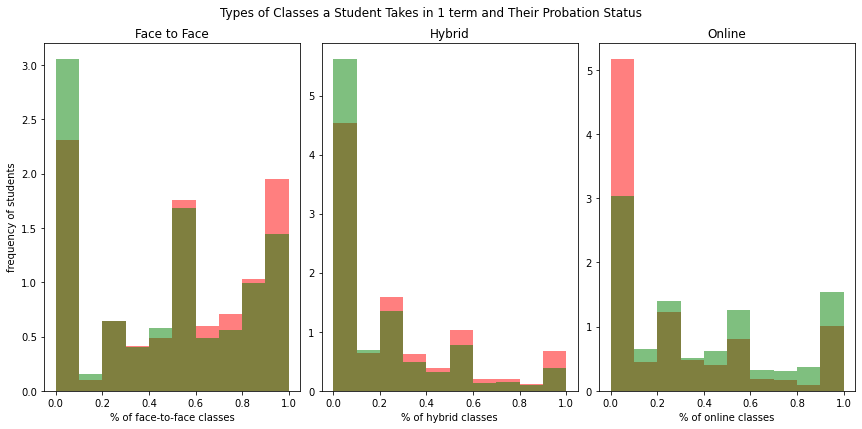

In [25]:
# plotting histograms
plt.rcParams['figure.figsize'] = [12,6]
  
fig, axs = plt.subplots(1,3, sharex = True)

axs[0].hist(onProb['%f2f'], label='onProb', color = 'red', alpha = 0.5, density = True)
axs[0].hist(notProb['%f2f'],label='notProb', color = 'green', alpha = 0.5, density = True)
axs[0].set_title('Face to Face')

axs[1].hist(onProb['%hybrid'], label='onProb', color = 'red', alpha = 0.5, density = True)
axs[1].set_title('Hybrid')
axs[1].hist(notProb['%hybrid'], label='notProb', color = 'green', alpha = 0.5, density = True)

axs[2].hist(onProb['%online'],label='onProb', color = 'red', alpha = 0.5, density = True)
axs[2].hist(notProb['%online'],label='notProb', color = 'green', alpha = 0.5, density = True)
axs[2].set_title('Online')
  


axs[0].set_xlabel('% of face-to-face classes')
axs[1].set_xlabel('% of hybrid classes')
axs[2].set_xlabel('% of online classes')

axs[0].set_ylabel('frequency of students')
fig.suptitle('Types of Classes a Student Takes in 1 term and Their Probation Status')
fig.tight_layout(pad =  0.8)
plt.show()

#Stuff that i notice:
# what's up with the 0 classes of each type?

In [61]:
probHybridCounts = [1,1,1,1,1,1,1,1,1,1,1]
#how many have 0% hybrid, 10% hybrid, ... 100% hybrid
for i in range(len(probHybridCounts)):
    probHybridCounts[i] = len(onProb[(onProb['%hybrid'] > (i*0.1)) & (onProb['%hybrid'] <=((i+1)*0.1)) ])
probHybridCounts



[9, 1187, 656, 792, 739, 168, 166, 239, 22, 563, 0]

# 1B) class modality and end of term gpa

In [26]:
#take only the relevant features for this exploration
onlineGPA = yearData[['encrypt_id', 'term', 'modality', 'semester_gpa']]

#make new columns for getting proportions of each class type
onlineGPA[['%f2f', '%online', '%hybrid']] = 0

onlineGPA = onlineGPA.apply(enumClassType, axis = 1)
onlineGPA.head(15)

C:\Users\Isabel\AppData\Local\Temp\ipykernel_10096\2780326265.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onlineGPA[['%f2f', '%online', '%hybrid']] = 0
C:\Users\Isabel\AppData\Local\Temp\ipykernel_10096\2780326265.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onlineGPA[['%f2f', '%online', '%hybrid']] = 0
C:\Users\Isabel\AppData\Local\Temp\ipykernel_10096\2780326265.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,encrypt_id,term,modality,semester_gpa,%f2f,%online,%hybrid
0,16548746,202220,Face-to-Face|SFA Campus,2.86,1,0,0
1,6309900,202220,Livestream & Face-to-Face,1.00,0,0,1
3,6309900,202220,Livestream & Face-to-Face,1.00,0,0,1
5,6309900,202220,Livestream & Face-to-Face,1.00,0,0,1
6,6309900,202220,Livestream & Face-to-Face,1.00,0,0,1
7,6309900,202220,Livestream & Face-to-Face,1.00,0,0,1
8,4929642,202220,Online,3.50,0,1,0
9,4929642,202220,Online,3.50,0,1,0
11,25980993,202220,Livestream & Face-to-Face,4.00,0,0,1
13,25980993,202220,Livestream & Face-to-Face,4.00,0,0,1


In [27]:
test = onlineGPA.loc[onlineGPA['semester_gpa'] == 0]
test.info()
#why are some semester gpa's 0?
#the only entries in onlineGPA dataframe are classes that have a final grade

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24838 entries, 346 to 47031
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   encrypt_id    24838 non-null  int64  
 1   term          24838 non-null  int64  
 2   modality      24838 non-null  object 
 3   semester_gpa  24838 non-null  float64
 4   %f2f          24838 non-null  int64  
 5   %online       24838 non-null  int64  
 6   %hybrid       24838 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 1.5+ MB


In [28]:
onlineGPA = onlineGPA.loc[onlineGPA['semester_gpa'] > 0]

In [29]:
#drop the term column
onlineGPA = onlineGPA[['encrypt_id', 'term', '%f2f', '%hybrid', '%online', 'semester_gpa']]

#find counts for each class type.
#there is an entry for each student each term. keeping terms separate
onlineGPA = onlineGPA.groupby(['encrypt_id','term']).sum()

#find the total number of classes a student took that term
onlineGPA['numClasses'] = onlineGPA['%f2f'] + onlineGPA['%online'] + onlineGPA['%hybrid']
onlineGPA['semester_gpa'] = onlineGPA['semester_gpa'] / onlineGPA['numClasses']
onlineGPA.head()

,,%f2f,%hybrid,%online,semester_gpa,numClasses
encrypt_id,term,,,,,
2154,202220,2,0,4,2.67,6
2954,202210,2,0,3,3.00,5
3952,202220,0,1,1,4.00,2
12999,202220,2,0,1,2.85,3
17507,202220,2,2,0,3.54,4


# CLASS TIME AFFECTING PROBATION

C:\Users\Isabel\AppData\Local\Temp\ipykernel_10096\1601193189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classTime.dropna(inplace = True)


array([[<AxesSubplot:title={'center':'encrypt_id'}>,
        <AxesSubplot:title={'center':'term'}>],
       [<AxesSubplot:title={'center':'start_time'}>,
        <AxesSubplot:title={'center':'probation'}>]], dtype=object)

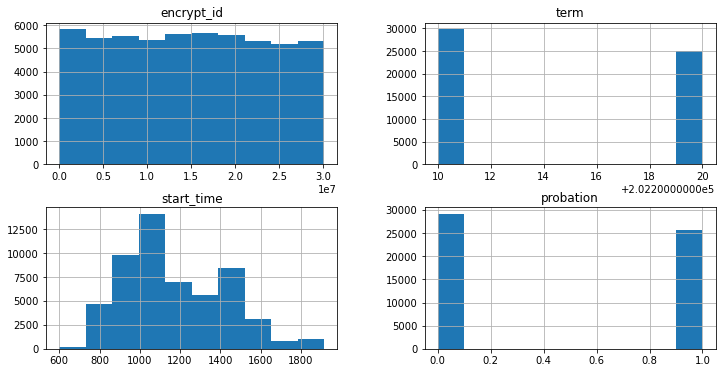

In [30]:
classTime = yearData[['encrypt_id', 'term', 'start_time', 'probation']]
classTime.dropna(inplace = True)
classTime = classTime[classTime['start_time'] > 500]
classTime.hist()

In [31]:
ctProb = classTime[classTime['probation'] == 1]
ctNotProb = classTime[classTime['probation'] == 0]
ctNotProb.head(10)

,encrypt_id,term,start_time,probation
11,25980993,202220,1000.0,0.0
24,12796052,202220,1845.0,0.0
38,937190,202220,1845.0,0.0
49,19333255,202220,1230.0,0.0
50,19333255,202220,1800.0,0.0
52,24412159,202220,800.0,0.0
53,24412159,202220,1200.0,0.0
64,5986606,202220,800.0,0.0
66,5986606,202220,1100.0,0.0
67,5986606,202220,1230.0,0.0


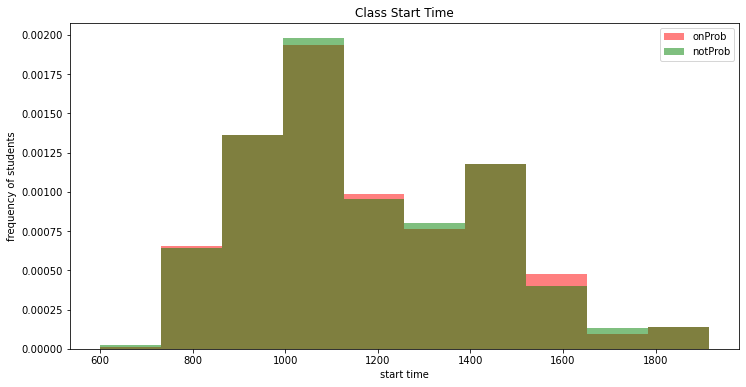

In [32]:
plt.hist(ctProb['start_time'], alpha = 0.5, label='onProb', color = 'red', density = True)
  
plt.hist(ctNotProb['start_time'],alpha = 0.5, label='notProb', color = 'green', density = True)
  
plt.legend(loc='upper right')
plt.title('Class Start Time')
plt.xlabel('start time')
plt.ylabel('frequency of students')
plt.show()